## Erick Iván Castro Granados 

## ITAM 

## Tarea PCA

In [1]:
import numpy as np
from numpy.linalg import svd
from sklearn.decomposition import PCA
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

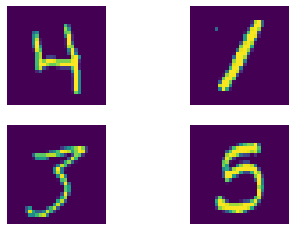

In [2]:
train, test = datasets.mnist.load_data()
xtrain, ytrain = train

np.random.seed(3141)
indices = np.random.choice(np.arange(len(xtrain)), size=4)
fig, ax = plt.subplots(2, 2)
for axi, ix in zip(ax.ravel(), indices):
    axi.imshow(xtrain[ix])
    axi.axis("off")

In [8]:
ytrain

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [11]:
%%time
N, M1, M2 = xtrain.shape
X = xtrain.reshape(N, -1)[:int(N * 0.5)]
y = ytrain[:int(N * 0.5)]
mu = X.mean(axis=0, keepdims=True)
X = X - mu
U, Sigma, Vt = svd(X, full_matrices=False)

Wall time: 2.82 s


## Considerando xtrain, ytrain definido en las céldas de arriba, crea dos modelos:
1- Un pipeline considerando PCA con n_components=0.7, seguido de un modelo KNeighborsClassifier con n_neighbors=5 

2- KNeighborsClassifier con n_neighbors=5


In [12]:
modelo1 = Pipeline([
    ("PCA", PCA(n_components=0.7)),
    ("KNC", KNeighborsClassifier(n_neighbors=5))
])

modelo2 = KNeighborsClassifier(n_neighbors=5)

In [15]:
ajuste1 = modelo1.fit(xtrain.reshape(N, -1),ytrain)
ajuste1

Pipeline(memory=None,
         steps=[('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=0.7,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('KNC',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [16]:
ajuste2 = modelo2.fit(xtrain.reshape(N, -1),ytrain)
ajuste2

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

## Realiza un cross validation con cv=3.
¿Qué resultados arroja cada modelo?

¿Qué ventajas tiene cada modelo?

¿Cuánto tarda en correr cada cross-validation?

In [17]:
%%time
cv = cross_validate(modelo1, xtrain.reshape(N, -1), ytrain, cv=3)

Wall time: 2min 11s


In [ ]:
%%time
cv2 = cross_validate(modelo2, xtrain.reshape(N, -1), ytrain, cv=3)
score2 = cv["test_score"]

In [19]:
score1 = cv["test_score"]
print(f"El score para el modelo 1 es: {round(100*score1.mean()):0.2f}%")

El score para el modelo 1 es: 97.00%


In [ ]:
print(f"El score para el modelo 2 es: {round(100*score2.mean()):0.2f}%")

Una de las desventajas más grandes del model que solo tiene KNeighborsClassifier, es que tarda demasiado en correr. 
Para hacer la prueba de Cross Validate se ha tardado demasiado. 

Para el pipeline que incluso PCA y KNeighborsClassifier, aunque también tardó un poco en arrojar un resultado, no se compara a lo mucho que tardó el otro. Aparte con un test score de 97% que lo hace más que aceptable. 

El primero model tardó 2 minutos 11 segundo en hacer la prueba de CV. 
El segundo modelo tardó demasiado, llevaba mas de 30 minutos y tuve que pararlo. 

## Demostración 

La idea es demostrar que AdaBoost.M1 es equivalente a un modelo aditivo progresivo por etapas, usando la función de perdida 
$$
L(y,f(x))=\exp(-yf(x))
$$
Para Adaboost, las funciones base son clasificadores individuales tales que $G_m(x)\in \{-1,1\}$. Usando la función de perdida anterior, tenemos que resolver: 
$$
(\beta_m,G_m)=argmin_{\beta,G} \sum_{i=1}^{N}\exp[-y_i(f_{m-1}(x_i)+\beta G(x_i))]
$$
para la función de clasificación $G_m$ y su coeficiente correspondiente $\beta_m$, aditivos para cada paso. La formula anterior se puede expresar se la siguiente manera:
$$
(\beta_m,G_m)=argmin_{\beta,G} \sum_{i=1}^{N}w_i^{(m)}\exp(-\beta y_i G(x_i))  
$$
con $w_i^{(m)}=\exp(-y_i f_{m-1}(x_i))$. Como cada $w_i^{(m)}$ no depende ni de $\beta$ ni de $G(x)$, puede ser considerado como un peso que es aplicado a cada observación. Estos pesos dependen de $f_{m-1}(x_i)$, y su valor cambia con cada iteración $m$.

La solución para la expresión anterior se puede obtener en dos pasos. El primero, para todo valor de $\beta > 0$, la solución a la expresión para $G_m(x)$ es: 
$$
G_m = argmin_G \sum_{i=1}^N w_i^{(m)} I(y_i\neq G(x_i))
$$
que es la función de clasificación que minimiza la tasa de error ponderada a la hora de predecir y. Esto se puede notar mostrando la expresión para $(\beta_m,G_m)$ de la siguiente manera:
$$
e^{-\beta}\sum_{y_i=G(xi)}w_i^{(m)} + e^{\beta}\sum_{y_i\neq G(xi)}w_i^{(m)}
$$
que a su vez puede ser escrito como: 
$$
(e^\beta - e^{-\beta})\sum_{i=1}^N w_i^{(m)}I(y_i\neq G(x_i)) + e^{-\beta}\sum_{i=1}^N w_i^{(m)}
$$
Reemplazando $G_m$ en la expresión para $(\beta_m,G_m)$ y despejando $\beta$ obtenemos: 
$$
\beta_m = \frac{1}{2}\log\frac{1-err_m}{err_m}
$$
donde $err_m$ es la tasa minima de error ponderada
$$
err_m = \frac{\sum_{i=1}^N w_i^{(m)}I(y_i\neq G_m(x_i))}{\sum_{i=1}^N w_i^{(m)}}
$$
La función de aproximación es actualizada 
$$
f_m(x)=f_{m-1}(x)+\beta_m G_m(x)
$$
que ocasiona que los pesos para la siguiente iteración sean: 
$$
w_i^{m+1}=w_i^{m}e^{-\beta_my_iG_m(x_i)}
$$
Usando el hecho de que $-y_iG_m(x_i) = 2I(y_i\neq G_m(x_i))-1$, los pesos terminan siendo:
$$
w_i^{m+1}=w_i^{m}e^{\alpha_mI(y_i\neq G_m(x_i))}e^{-\beta_m}
$$
donde $\alpha_m = 2\beta_m$ es una cantidad definida en el algoritmo de Adaboost.M1. El factor $e^{-\beta_m}$ que multiplica a todos los pesos por el mismo valor, hace que se neutralice su efecto. Por lo tanto eso lo hace equivalente al algoritmo de un modelo aditivo progresivo.